In [1]:
import glob
import cv2 as cv
import numpy as np
import imutils
from matplotlib import pyplot as plt
from scipy import signal

In [11]:
def detect_5l(img,start,method,threshold=0.9):

    img2 = img.copy()
    res = cv.matchTemplate(img2,start,method)
    cv.normalize(res,res,0,1, norm_type=cv.NORM_MINMAX)
    

    loc = np.where(res > threshold)

    point_w = []
    point_h = []

    start_w,start_h = start.shape[::-1]
    
    for pt in zip(*loc[::-1]):
        cv.rectangle(img2, pt, (pt[0] + start_w, pt[1] + start_h), (0,0,255), 1)
        point_w.append(pt[0])
        point_h.append(pt[1])
    
    i = 1
    while i < len(point_h):
        prev = point_h[i-1]
        post = point_h[i]

        if (post-prev < 30):
            del point_h[i-1]
            del point_w[i-1]
        else:
            i += 1
    
    crops = []

    for i in range(len(point_h)):

        s = point_h[i]-start_h//2
        e = point_h[i]+start_h

        crops.append(img[s:e,point_w[i]+start_w:img.shape[1]])
    
    return img2, point_w, point_h, crops

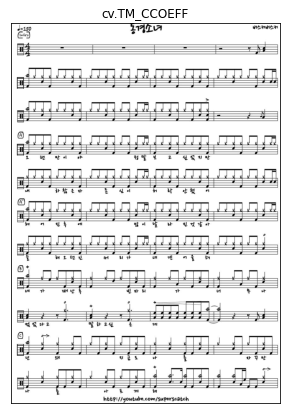

In [54]:
music_sheet = cv.imread('C:/Users/ADmin/Desktop/drum/music_sheet/'+'/4.jpg',0)

start = cv.imread('C:/Users/ADmin/Desktop/start.jpg',0)

meth = 'cv.TM_CCOEFF'
method = eval(meth)

img2, _, _, crops = detect_5l(music_sheet,start,method,0.9)
    
plt.figure(figsize=[10,7])
plt.imshow(img2,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.title(meth)
plt.show()

In [65]:
def detect_nl(crop_img,method,threshold=0.7):
    crop_img2 = crop_img.copy()
    half_img = crop_img[0:crop_img.shape[0]//3,:]
    
    line = np.zeros([half_img.shape[0],1])
    padd = np.ones([half_img.shape[0],1])

    lines = np.hstack([padd, line, line, line, padd])
    lines = lines.astype(np.uint8)
    
    lines_w,lines_h = lines.shape[::-1]
    
    res = cv.matchTemplate(half_img,lines,method)
    res_norm = res.copy()
    cv.normalize(res,res_norm,0,1, norm_type=cv.NORM_MINMAX)
    
    loc = np.where(res_norm > threshold)
    
    point_w = []
    point_h = []
    
    for pt in zip(*loc[::-1]):
        cv.rectangle(crop_img2, (pt[0] - 10, pt[1]), (pt[0] + 10, pt[1] + crop_img.shape[0]), 0, 1)
        point_w.append(pt[0])
        point_h.append(pt[1])
    
    profile = res_norm.T
    
    result = crop_img2
    
    return half_img, result, profile

(0.0, 816.0)

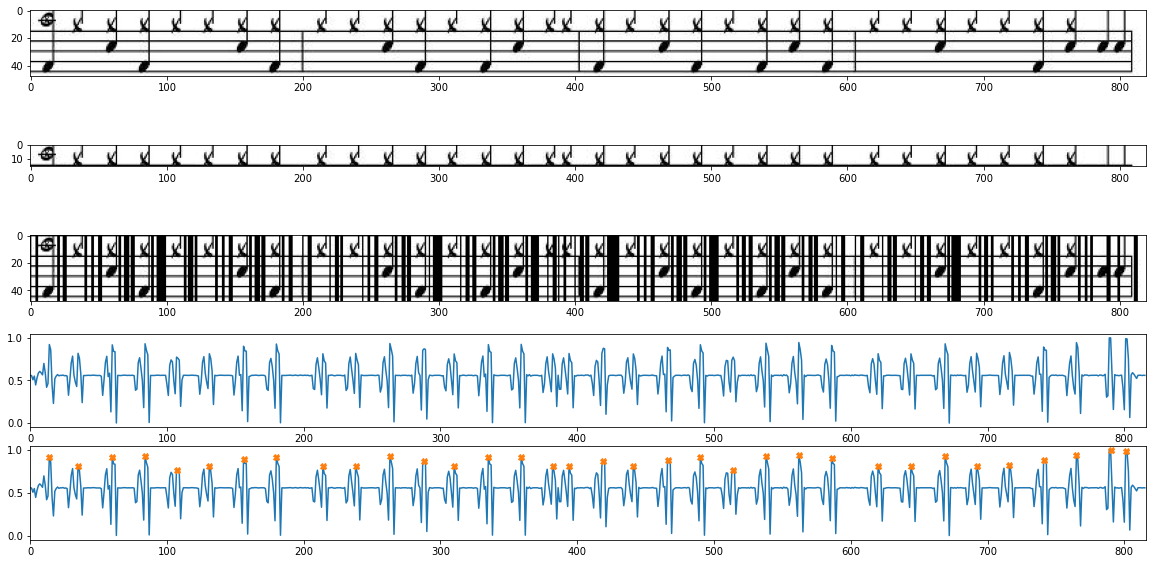

In [66]:
crop_img = crops[1]

half_img, result, profile = detect_nl(crop_img,method,threshold=0.7)
  
prof = np.squeeze(profile, axis=1) 
peaks,_ = signal.find_peaks(prof, height=0.65, distance=8)

plt.figure(figsize=[20,10])
plt.subplot(5,1,1),plt.imshow(crop_img,cmap = 'gray')
plt.subplot(5,1,2),plt.imshow(half_img,cmap = 'gray')  
plt.subplot(5,1,3),plt.imshow(result,cmap = 'gray')
plt.subplot(5,1,4),plt.plot(profile)
plt.xlim(0,len(profile))
plt.subplot(5,1,5),plt.plot(profile),plt.plot(peaks,profile[peaks],"X")
plt.xlim(0,len(profile))

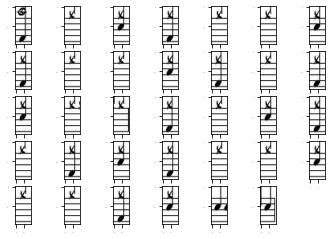

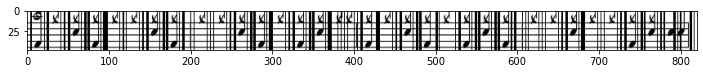

In [67]:
note_crops = []

peak_point = peaks

for i in range(len(peaks)):
    
    crops = crop_img[0:crop_img.shape[0],peak_point[i]-10:peak_point[i]+10]
    note_crops.append(crops)
    
for i in range(len(note_crops)):
    plt.subplot(5,len(note_crops)//5+1,i+1)
    plt.imshow(note_crops[i],cmap='gray')
    plt.xticks(fontsize=0.1)
    plt.yticks(fontsize=0.1)
    
plt.figure(figsize=[12,5])
plt.imshow(crop_img2,cmap = 'gray')

In [68]:
def one_or_two(note_crop, method):
    process_img = note_crop.copy()
    img = note_crop.copy()
    
    square = np.zeros([7,7])
    square = np.pad(square,(2,2),mode = 'constant', constant_values = 1)
    square = square.astype(np.uint8)

    orig_res = cv.matchTemplate(process_img,square,method)
    
    points = []
    
    for i in range(2):
        res = cv.matchTemplate(process_img,square,method)
        res_norm = res.copy()

        cv.normalize(res,res_norm,0,1, norm_type=cv.NORM_MINMAX)

        minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(res_norm)

        x,y = minLoc
        h,w = square.shape        

        if i == 0:
            process_img[y:y+h, x:x+w] = np.max(process_img)
            cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 1)
        else:
            avg = np.mean(process_img[y:y+h, x:x+w])

            if avg < 180:
                cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 1)
                print ("two note")
            else:
                print ("one note")
                break
        
        point = x+w//2,y+h//2
        points.append(point)
                
    return orig_res,img,points

two note
[(10, 40), (9, 11)]


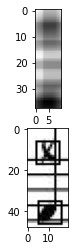

In [69]:
meth = 'cv.TM_SQDIFF'
method = eval(meth)

note_crop = note_crops[20]
orig_res, img, points = one_or_two(note_crop, method)

print(points)

plt.figure(figsize=[10,4])
plt.title(method)
plt.subplot(2,1,1), plt.imshow(orig_res,cmap = 'gray')
plt.subplot(2,1,2), plt.imshow(img,cmap = 'gray')

plt.show()

<StemContainer object of 3 artists>

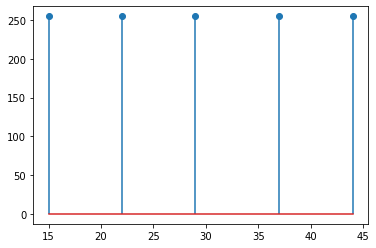

In [70]:
f_line = note_crop[:,3]
for i in range(len(f_line)):
    if f_line[i] < 100:
        f_line[i] = 255
    else:
        f_line[i] = 0

line = np.where(f_line==255)[0]

i = 1
while i < len(line):
    prev = line[i-1]
    post = line[i]

    if (post-prev == 1):
        line =np.delete(line,i-1)
    else:
        i += 1
plt.stem(line, f_line[line])    

In [71]:
ride = [0,line[0]-7]
hihat = [line[0]-7,line[0]]
snare = [line[2] - 1,line[2] + 1]
h_tom = [(line[0]+line[1])//2 - 1,(line[0]+line[1])//2 + 1]
m_tom = [(line[1]+line[2])//2 - 1,(line[1]+line[2])//2 + 1]
l_tom = [(line[2]+line[3])//2 - 1,(line[2]+line[3])//2 + 1]
bass = [(line[3]+line[4])//2 - 1,(line[3]+line[4])//2 + 1]

note = []
for i in range(len(points)):
    if ride[0] <= points[i][1] <=  ride[1]:
        note.append('Ride')
    elif hihat[0] <= points[i][1] <=  hihat[1]:
        note.append('Hihat')
    elif snare[0] <= points[i][1] <=  snare[1]:
        note.append('Snare')
    elif h_tom[0] <= points[i][1] <=  h_tom[1]:
        note.append('High_Tom')
    elif m_tom[0] <= points[i][1] <=  m_tom[1]:
        note.append('Mid_Tom')
    elif l_tom[0] <= points[i][1] <=  l_tom[1]:
        note.append('Low_Tom')   
    else:
        note.append('Bass')     

In [72]:
note

['Bass', 'Hihat']